<h1 align="center">Sentiment Analysis</h1>

### Importing Libraries

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Flatten, Embedding, RNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, classification_report, accuracy_score

from lime import lime_text
from lime.lime_text import LimeTextExplainer

### Loading Data

In [2]:
with open('merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.reset_index(drop=True, inplace=True)
data.head()

text emotions
0  i feel awful about it too because it s my job ...  sadness
1                              im alone i feel awful  sadness
2  ive probably mentioned this before but i reall...      joy
3           i was feeling a little low few days back  sadness
4  i beleive that i am much more sensitive to oth...     love

In [4]:
data['len'] = [len(x.split()) for x in data['text']]
data.head()

text emotions  len
0  i feel awful about it too because it s my job ...  sadness   26
1                              im alone i feel awful  sadness    5
2  ive probably mentioned this before but i reall...      joy   27
3           i was feeling a little low few days back  sadness    9
4  i beleive that i am much more sensitive to oth...     love   18

### Exploring Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
 2   len       416809 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


In [6]:
print(f"number of duplicate: {data.duplicated().sum()} tweets")
data.drop_duplicates(inplace=True)

number of duplicate: 686 tweets


joy         140779
sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: emotions, dtype: int64


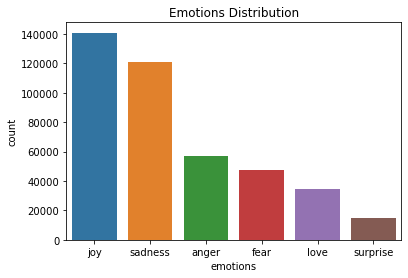

In [7]:
v = data['emotions'].value_counts()
classes = np.unique(data['emotions'])
n_classes = len(classes)
sns.barplot(x=v.index, y=v.values)
plt.xlabel('emotions')
plt.ylabel('count')
plt.title('Emotions Distribution')
print(f"{v}")

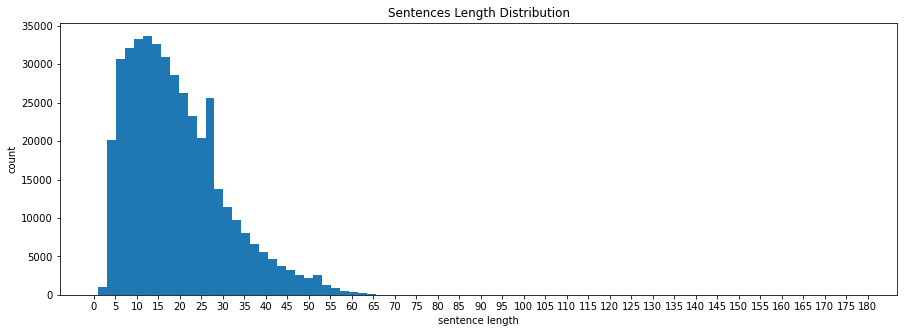

In [8]:
xticks = [i for i in range(0, data['len'].max()+5, 5)]
plt.figure(figsize=(15,5))
plt.hist(data['len'], bins=len(set(data['len'])))
plt.xlabel('sentence length')
plt.ylabel('count')
plt.xticks(xticks)
plt.title('Sentences Length Distribution');

Log scaled

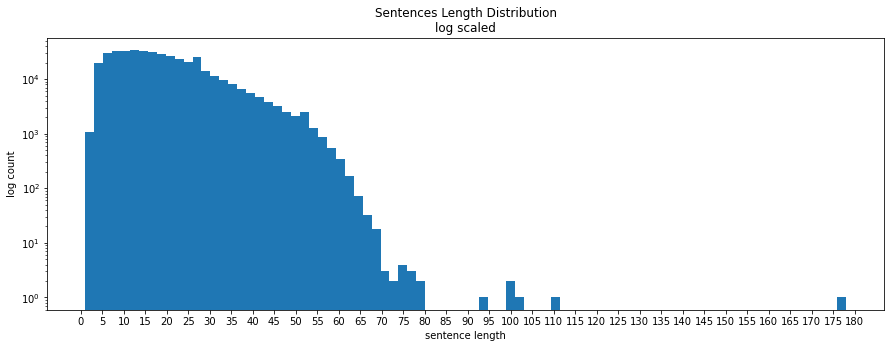

In [9]:
plt.figure(figsize=(15,5))
plt.hist(data['len'], bins=len(set(data['len'])))
plt.xlabel('sentence length')
plt.ylabel('log count')
plt.yscale('log')
plt.xticks(xticks)
plt.title('Sentences Length Distribution\nlog scaled');

### Comparing Emotions Features

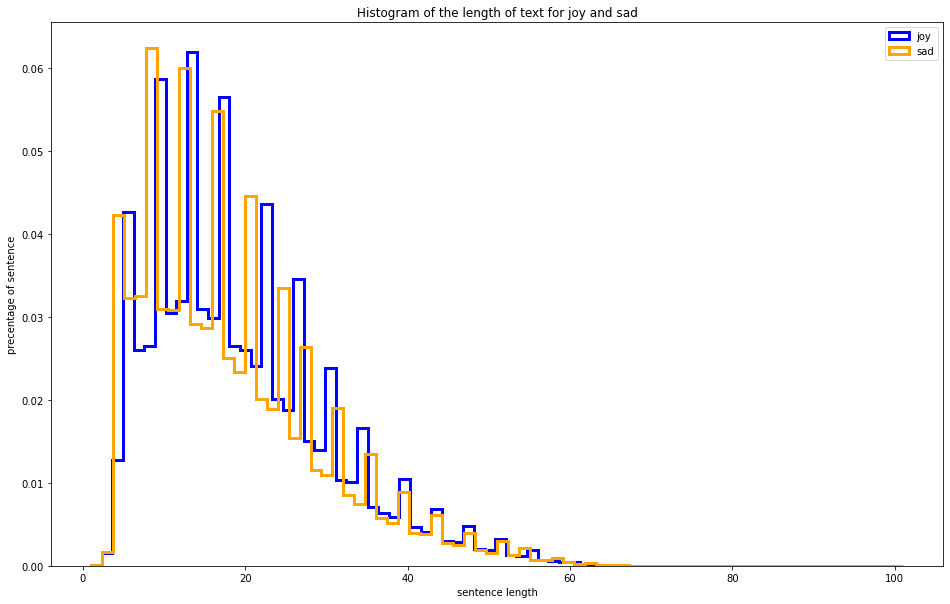

In [10]:
lens = []

joy_df = data.query('emotions == "joy"')
joy_len = joy_df['len']
lens.append(np.array(joy_len))

sad_df = data.query('emotions == "sadness"')
sad_len = sad_df['len']
lens.append(np.array(sad_len))

plt.figure(figsize=(16, 10))
plt.hist(joy_len, density=True, histtype = "step", bins=len(set(joy_len)), color='blue', label='joy', linewidth=3)
plt.hist(sad_len, density=True, histtype = "step", bins=len(set(sad_len)), color='orange', label='sad', linewidth=3)
plt.legend()
plt.xlabel('sentence length')
plt.ylabel('precentage of sentence')
plt.title('Histogram of the length of text for joy and sad')
plt.show()

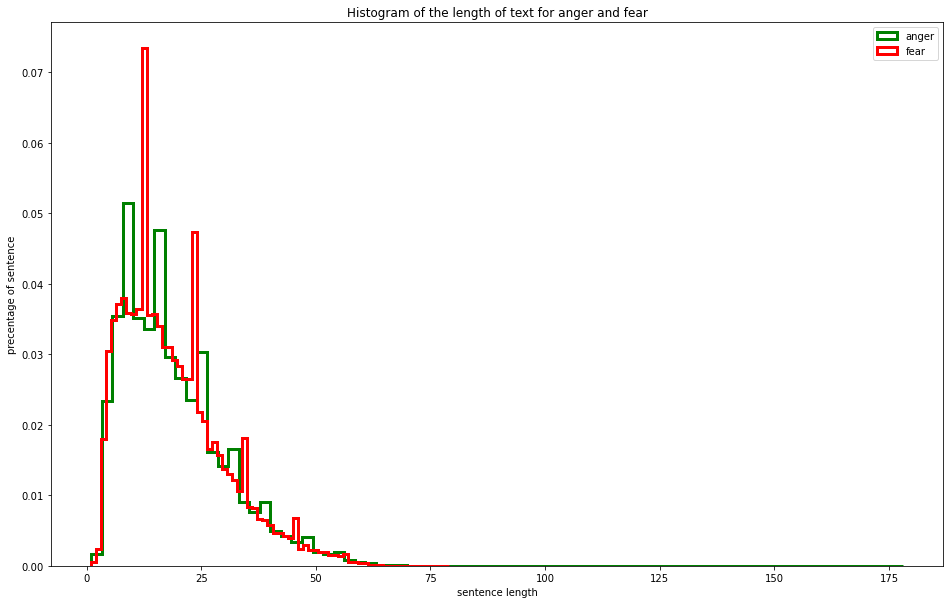

In [11]:
anger_df = data.query('emotions == "anger"')
anger_len = anger_df['len']
lens.append(np.array(anger_len))

fear_df = data.query('emotions == "fear"')
fear_len = fear_df['len']
lens.append(np.array(fear_len))

plt.figure(figsize=(16, 10))
plt.hist(anger_len, density=True, histtype = "step", bins=len(set(anger_len)), color='green', label='anger', linewidth=3)
plt.hist(fear_len, density=True, histtype = "step", bins=len(set(fear_len)), color='r', label='fear', linewidth=3)
plt.legend()
plt.xlabel('sentence length')
plt.ylabel('precentage of sentence')
plt.title('Histogram of the length of text for anger and fear')
plt.show()

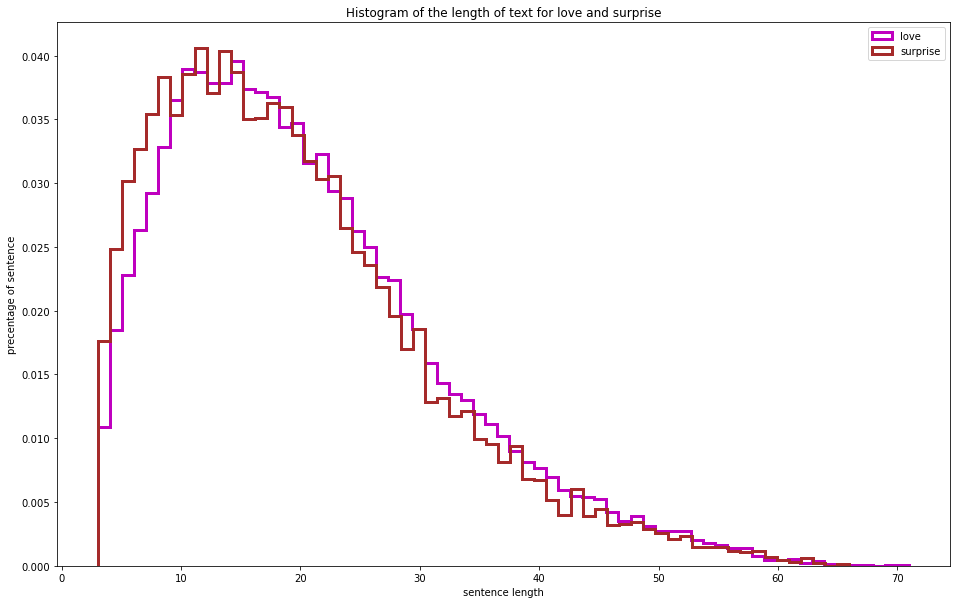

In [12]:
love_df = data.query('emotions == "love"')
love_len = love_df['len']
lens.append(np.array(love_len))

surprise_df = data.query('emotions == "surprise"')
surprise_len = surprise_df['len']
lens.append(np.array(surprise_len))

plt.figure(figsize=(16, 10))
plt.hist(love_len, density=True, histtype = "step", bins=len(set(love_len)), color='m', label='love', linewidth=3)
plt.hist(surprise_len, density=True, histtype = "step", bins=len(set(surprise_len)), color='brown', label='surprise',
         linewidth=3)
plt.legend()
plt.xlabel('sentence length')
plt.ylabel('precentage of sentence')
plt.title('Histogram of the length of text for love and surprise')
plt.show()

the average length of a sentence for each class

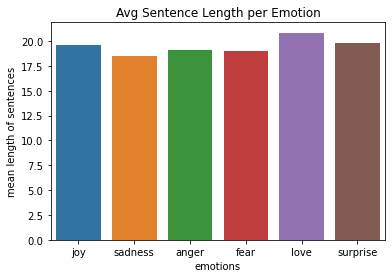

In [13]:
lens = np.array(lens, dtype='object')
lens_mean = [x.mean() for x in lens] 
sns.barplot(x=v.index, y=lens_mean)
plt.xlabel('emotions')
plt.ylabel('mean length of sentences')
plt.title('Avg Sentence Length per Emotion');

### Helper Functions

In [14]:
# function to plot the confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return cm

In [15]:
# from class labels to indices and from indices to class labels
c_to_i = dict((v, i) for i, v in enumerate(classes))
i_to_c = dict((i, v) for i, v in enumerate(classes))
to_indices = lambda labels: np.array([c_to_i.get(x) for x in labels])
to_classes = lambda idx: np.array([i_to_c.get(x) for x in idx])

Preprocessing Text Function

In [16]:
def preprocess(X, tokenizer=None, padded=True):
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
        tokenizer.fit_on_texts(X)
        seq = tokenizer.texts_to_sequences(X)
        tmp = seq
        seq_padded = pad_sequences(seq, maxlen=50, padding='post', truncating='post')
        return tokenizer, seq_padded
    seq = tokenizer.texts_to_sequences(X)
    seq_padded = pad_sequences(seq, maxlen=50, padding='post', truncating='post')
    return seq_padded

Ploting Progress Function

In [17]:
def plot_progress(train_loss, val_loss, train_acc, val_acc, epochs):
    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='train loss')
    plt.plot(epochs_range, val_loss, label='val loss')
    plt.legend()
    plt.title('Train&Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label='train acc')
    plt.plot(epochs_range, val_acc, label='val acc')
    plt.legend()
    plt.title('train&Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy');

### Checking for Gpu

In [18]:
if not tf.test.gpu_device_name():
    print('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [19]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Creating The Model

Model 1

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 32, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
initial_weights = 'initial_weights'
model.save_weights(initial_weights)

# Dataset As Is (Imbalanced)

## LSTM Approcah Using Keras

Spliting Data

In [22]:
text = data['text'].values
y = data['emotions'].values

y_sparse = to_indices(y)
# y_hot = to_categorical(y_sparse)

X_train, X_test, y_train, y_test = train_test_split(text, y_sparse, test_size=0.2)

Preprocessing Text

In [23]:
tokenizer, X_train_processed  = preprocess(X_train)
X_test_processed = preprocess(X_test, tokenizer)

In [24]:
%%time
epochs = 2
# checkpoint = ModelCheckpoint('sparse_model_dl_W_1.h5', save_weights_only=True)

history = model.fit(X_train_processed, y_train, validation_split=0.2, epochs=epochs, batch_size=32)

Train on 266318 samples, validate on 66580 samples
Epoch 1/2
266318/266318 [==============================] - 113s 425us/sample - loss: 0.2813 - accuracy: 0.8855 - val_loss: 0.1210 - val_accuracy: 0.9314
Epoch 2/2
266318/266318 [==============================] - 107s 400us/sample - loss: 0.1030 - accuracy: 0.9381 - val_loss: 0.0972 - val_accuracy: 0.9379
Wall time: 3min 39s


Model Progress

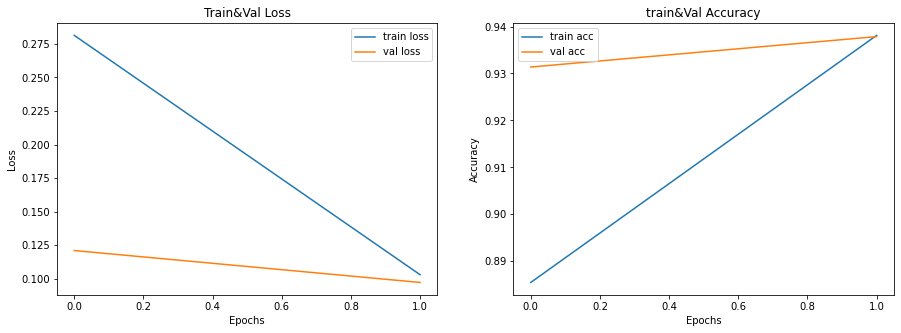

In [25]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plot_progress(train_loss, val_loss, train_acc, val_acc, epochs)

### Evaluating

In [26]:
%%time
model.evaluate(X_test_processed, y_test, verbose=0)

Wall time: 12.1 s


[0.09617364916193992, 0.9386843]

In [27]:
preds = model.predict_classes(X_test_processed)#.argmax(axis=1)

print(classification_report(y_test, preds, target_names=classes))

              precision    recall  f1-score   support

       anger       0.94      0.94      0.94     11363
        fear       0.89      0.92      0.90      9480
         joy       0.99      0.92      0.95     28217
        love       0.79      0.97      0.87      6922
     sadness       0.97      0.98      0.97     24251
    surprise       0.89      0.72      0.80      2992

    accuracy                           0.94     83225
   macro avg       0.91      0.91      0.91     83225
weighted avg       0.94      0.94      0.94     83225



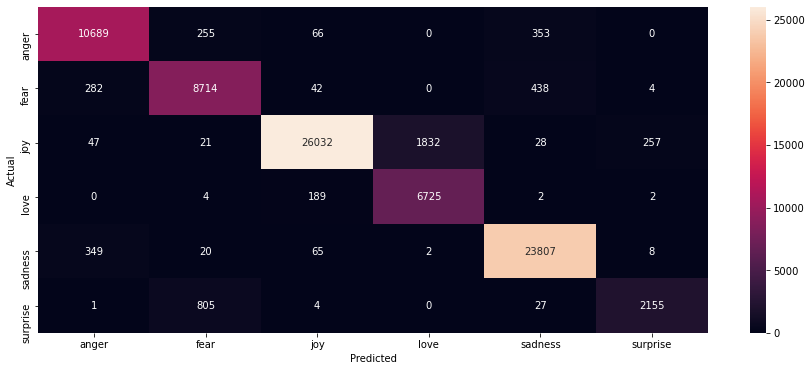

In [28]:
cm = show_confusion_matrix(y_test, preds, classes)

### Getting the Wrong and Correct Predictions

In [29]:
x = (preds != y_test)

wrong_preds, wrong_pred_texts, true_labels = to_classes(preds[x]), X_test[x], to_classes(y_test[x])
correct_preds, correct_pred_texts, correct_true_labels = to_classes(preds[~x]), X_test[~x], to_classes(y_test[~x])

In [30]:
wrong_df = pd.DataFrame(data={'text': wrong_pred_texts, 'label':true_labels, 'prediction':wrong_preds})
pd.options.display.max_colwidth = 500
wrong_df

text  \
0                                                                                                                                                                        i feel hinky about supporting the gaming industry even indian casinos and don t really like the atmosphere   
1                                                                                                                                                                 i was physically assaulted and sexually abused about a year ago just the feeling that i might not get away intact   
2                                                                                                  i have the emotions but have learned that to feel them to let myself become agitated or excited means that my heart and heat jumps the regulated limits of what can be sustained   
3                                                                                                                                                    i was feeling generous so i also caught a house fly to feed the black widow id caught in a mason jar so it could feast as well   
4     i pray my real friends here will understand why for the next few weeks my blogs will be short comments few and silence will reign from me while i am in the room if at all for i know its mostly in my head but i also hurt when i begin to feel unwelcome every where i look   
...                                                                                                                                                                                                                                                                             ...   
5098                                                                                                                                                                                                  i feel these pricklies all over and i feel agitated inside angry and confused   
5099                                                                                                                                                                                                                                                   i do an enema i feel amazing   
5100                                                                                                                                                                                                       a shop in downtown wouldnt accept my visa card before december last year   
5101                                                                                                                                                                                                                                                   im just feeling very strange   
5102                                                                                                                                                              i said feeling strange uttering those words but space flight was still a pretty novel way of traveling in my time   

         label prediction  
0          joy       love  
1         fear    sadness  
2        anger       fear  
3          joy       love  
4      sadness        joy  
...        ...        ...  
5098     anger       fear  
5099       joy   surprise  
5100     anger        joy  
5101  surprise       fear  
5102  surprise       fear  

[5103 rows x 3 columns]

In [31]:
correct_df = pd.DataFrame(data={'text': correct_pred_texts, 'label':correct_true_labels, 'prediction':correct_preds})
correct_df

text  \
0      i had been feeling a strong desire to make music again and a strong desire to make this kind of music songs written and recorded before music became synthesized and computerized sounding when it was just simple beautiful songs and someone standing up and singing them   
1                                                                                                                                                                            ive finally spent enough time with most of these products to feel comfortable in giving them a review   
2                                                                                                                                                                                         i no longer need to feel anxious about losing him being irrational picturing tragedy etc   
3                                                                                                                                                                                                                                     im sure ill feel fabulous just like toni did   
4                                                                                                                                                                                                                             i have that feeling and it feels really ficking good   
...                                                                                                                                                                                                                                                                            ...   
78117                                                                                                                                                                                                           i have a touch of relational relational when i am feeling sociable   
78118                                                                                                                                                                                                                                                      i feel ashamed and weak   
78119                                                                                                                                      i was feeling disappointed in people and the conformity of daily life i would be pulled toward its promise of uniqueness and expression   
78120                                                                                                                                                                                                                                           i feel so discouraged what do i do   
78121                                                                                                                                                                                    i no ou a slow paced feel and artistic touch contrary to the things going on in the story   

         label prediction  
0          joy        joy  
1          joy        joy  
2         fear       fear  
3          joy        joy  
4          joy        joy  
...        ...        ...  
78117      joy        joy  
78118  sadness    sadness  
78119  sadness    sadness  
78120  sadness    sadness  
78121      joy        joy  

[78122 rows x 3 columns]

### Explaining the Preditions Using LIME Explainer 

In [32]:
# function that takes a string and preprocessed then predict it so that it can be used in the explain_instance function in lime explainer
def new_predict(txt):
    seq = tokenizer.texts_to_sequences(txt)
    padded_seq = pad_sequences(seq, maxlen=50, padding='post', truncating='post')
    p = model.predict(padded_seq)
    return p

In [33]:
exp = LimeTextExplainer(class_names=classes)

#### Explaing the Wrong Predictions

In [34]:
idx = 0
explained = exp.explain_instance(wrong_df.iloc[idx]['text'], new_predict, num_features=7, top_labels=2)
explained.show_in_notebook(text=wrong_df.iloc[idx]['text'])

In [35]:
import re
# searching for all tweets in the wrong predictions dataframe that have the word "hated" in it
X_hated = []
y_hated = []
hated_indicies = []
for i, (string, label) in enumerate(zip(wrong_df.text, wrong_df.label)):
    r = re.search(r"\bhated", string)
    if r:
        X_hated.append(r.string)
        y_hated.append(label)
        hated_indicies.append(i)
        
X_hated = np.asarray(X_hated)
y_hated = np.asarray(y_hated)
print(f"X: {X_hated.shape}\ny: {y_hated.shape}")

X: (312,)
y: (312,)


In [36]:
idx = hated_indicies[15]
explained = exp.explain_instance(wrong_df.iloc[idx]['text'], new_predict, num_features=7, top_labels=2)
explained.show_in_notebook(text=wrong_df.iloc[idx]['text'])
print(wrong_df.iloc[idx])

text          i need to find some kind of joy in hating myself b c thats the only true thing i know how to feel ive always hated myself
label                                                                                                                             anger
prediction                                                                                                                      sadness
Name: 218, dtype: object


the true label for this example is anger however the model predicted it as sadness . It looks like the model is confused with the "hated" word it gets a high probability with both the anger class and the sadness class. 

In [37]:
import re
# searching for all tweets in the test set that have "hated" in it
X_hated = []
y_hated = []
hated_indicies = []
for i, (string, label) in enumerate(zip(X_test, y_test)):
    r = re.search(r"\bhated", string)
    if r:
        X_hated.append(r.string)
        y_hated.append(label)
        hated_indicies.append(i)
        
X_hated = np.asarray(X_hated)
y_hated = np.asarray(y_hated)
print(f"X: {X_hated.shape}\ny: {y_hated.shape}")
eval_hated = model.evaluate(preprocess(X_hated, tokenizer), y_hated, verbose=0)
print(f"loss: {eval_hated[0]} acc: {eval_hated[1]}")

X: (606,)
y: (606,)
loss: 0.6767731002061674 acc: 0.48514851927757263


I evauated the model with the tweets in the test set that have "hated" word in it to see how the model will preform and it did bad.

In [38]:
preds_hated = model.predict_classes(preprocess(X_hated, tokenizer))
xx  = (preds_hated != y_hated)
wrong_hated, wrong_labels, wrong_pred_hated = X_hated[xx], to_classes(y_hated[xx]), to_classes(preds_hated[xx])

wrong_hated_df = pd.DataFrame(data={'tweet':wrong_hated, 'label':wrong_labels, 'prediction':wrong_pred_hated})
wrong_hated_df

tweet  \
0                                                                                                                                              i have the feeling this blog might be rated as most hated from readers   
1                          i like to see how jb and michelle feel about a disable child since they paractically hated on nadya suleman for having one and suggested she wait until her kids turn to do a reality show   
2                                                i realize that some of the techniques used on me did have negative consequences ie feeling like i hated the two people i should never feel hatred towards my parents   
3                                                                                                                                                                   i feel like im hated everytime i go to skateparks   
4    i couldn t know what he was feeling then i thought that he wished he could have been there with us too for each of us knew that however much we hated it at first it was an experience we would remember forever   
..                                                                                                                                                                                                                ...   
307                                                                                                                                                                                      i feel hated all of a sudden   
308                                                                                                                               i feel discriminated against hated and deprived of everything i had ever dreamed of   
309                                                                                                                      i was sitting in the corner stewing in my own muck feeling hated alone unworthy and violated   
310                                                                                                                                                i hated that feeling and hated hearing her explain that atmosphere   
311                                                                                                                                                                 i am so sorry youre feeling it because i hated it   

       label prediction  
0      anger    sadness  
1    sadness      anger  
2      anger    sadness  
3    sadness      anger  
4      anger    sadness  
..       ...        ...  
307  sadness      anger  
308  sadness      anger  
309  sadness      anger  
310    anger    sadness  
311    anger    sadness  

[312 rows x 3 columns]

In [39]:
correct_hated, correct_labels, correct_pred_hated = X_hated[~xx], to_classes(y_hated[~xx]), to_classes(preds_hated[~xx])

correct_hated_df = pd.DataFrame(data={'tweet':correct_hated, 'label':correct_labels, 'prediction':correct_pred_hated})
correct_hated_df

tweet  \
0                                                                                                                      i have always hated school done horribly was held back in second grade put in special ed and basically shamed my entire life and made to feel dumb   
1                                                                                                                                                                                     i feel hated there but had to remind my selfish self that none of this was about me   
2    i was so tired that i really contemplated giving the gym a miss but steve said if you can go when you feel like crap then you know you can do it anytime i hated him for saying but deep down thought he was right although id never let him know that monday th jan   
3                                                                                                                                                                             i feel like i should be hated and that everything that has happened to me is what i deserve   
4                                                                                                                                                                                                                   im feeling the kind of feeling which i hated the most   
..                                                                                                                                                                                                                                                                    ...   
289                                                                                                                                                                                      i loved feeling in charge but hated some of the responsibility that came with it   
290                                                                                                                                               i didnt feel like watching it again since i hated it so much the first time so i told his son to go ahead and put it on   
291                                                                                                                                                                                                                              ive this bad feeling that im being hated   
292                                                                                                                                                                                              i hated this step because it forced me to feel humiliated all over again   
293                                                                                                                                                                                                                                     i feel like im hated and despised   

       label prediction  
0    sadness    sadness  
1      anger      anger  
2    sadness    sadness  
3      anger      anger  
4      anger      anger  
..       ...        ...  
289    anger      anger  
290    anger      anger  
291  sadness    sadness  
292  sadness    sadness  
293    anger      anger  

[294 rows x 3 columns]

it seems like when the model sees "hated" in the context it tends to predict the tweet/text into sadness.

#### Explaing the Correct Predictions

In [40]:
idx = 0
explained = exp.explain_instance(correct_df.iloc[idx]['text'], new_predict, num_features=7, top_labels=2)
explained.show_in_notebook(text=correct_df.iloc[idx]['text'])

In [41]:
tweet = "I'm very angery and disapointing in you my loved one"
tweet_processed = preprocess([tweet], tokenizer)
z = to_classes(model.predict_classes(tweet_processed))[0]
z

'anger'

In [42]:
explained = exp.explain_instance(tweet, new_predict, num_features=7, top_labels=2)
explained.show_in_notebook(text=tweet)

In [43]:
X_angery = []
y_angery = []
for string, label in zip(X_test, y_test):
    r = re.search(r"\bangery", string)
    if r:
        X_angery.append(r.string)
        y_angery.append(label)
        
X_angery = np.asarray(X_angery)
y_angery = np.asarray(y_angery)
print(f"X: {X_angery.shape}\ny: {y_angery.shape}")
if len(y_angery) != 0:
    explained = exp.explain_instance(X_angery[0], new_predict, num_features=7, top_labels=2)
    explained.show_in_notebook(text=X_angery[0])

X: (0,)
y: (0,)


# Dealing With an Imbalnced Dataset

## 1- Under Sampling

In [44]:
min_class_count = min(data['emotions'].value_counts())

grouped = data.groupby('emotions')['text'].apply(lambda x: x.sample(min_class_count))
data_under = grouped.reset_index()
data_under.drop(['level_1'], axis=1, inplace=True)
data_under = data_under.sample(frac=1)
data_under.reset_index(inplace=True, drop=True)
data_under.emotions.value_counts()

love        14959
anger       14959
sadness     14959
fear        14959
surprise    14959
joy         14959
Name: emotions, dtype: int64

In [45]:
text = data_under['text'].values
y = data_under['emotions'].values

y_sparse = to_indices(y)
# y_hot = to_categorical(y_sparse)

X_train, X_test, y_train, y_test = train_test_split(text, y_sparse, test_size=0.2)

Preprocessing Text

In [46]:
tokenizer, X_train_processed  = preprocess(X_train)
X_test_processed = preprocess(X_test, tokenizer)

Resetting The Model

In [47]:
model.load_weights(initial_weights);

Training Phase

In [48]:
%%time
epochs = 2
# checkpoint = ModelCheckpoint('sparse_model_dl_W_1.h5', save_weights_only=True)

history = model.fit(X_train_processed, y_train, validation_split=0.2, epochs=epochs, batch_size=32)

Train on 57442 samples, validate on 14361 samples
Epoch 1/2
57442/57442 [==============================] - 23s 400us/sample - loss: 0.8882 - accuracy: 0.6474 - val_loss: 0.2801 - val_accuracy: 0.9136
Epoch 2/2
57442/57442 [==============================] - 23s 402us/sample - loss: 0.2172 - accuracy: 0.9301 - val_loss: 0.2207 - val_accuracy: 0.9252
Wall time: 46.1 s


Model Progress

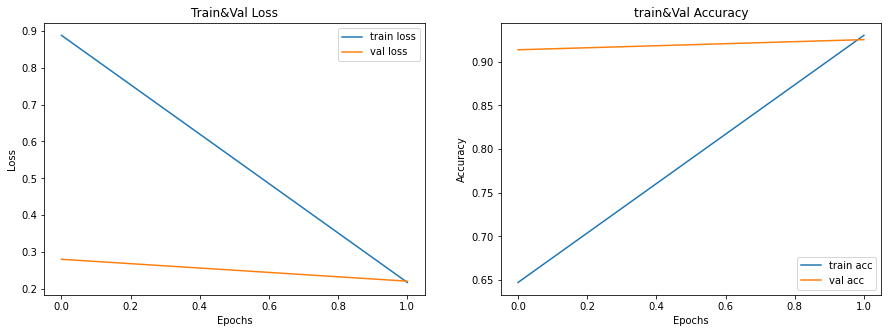

In [49]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plot_progress(train_loss, val_loss, train_acc, val_acc, epochs)

### Evaluating Phase

In [50]:
%%time
model.evaluate(X_test_processed, y_test, verbose=0)

Wall time: 2.68 s


[0.2188877266772603, 0.9270236]

In [51]:
preds = model.predict_classes(X_test_processed)

print(classification_report(y_test, preds, target_names=classes))

              precision    recall  f1-score   support

       anger       0.95      0.91      0.93      3009
        fear       0.93      0.88      0.90      3017
         joy       0.97      0.87      0.91      2971
        love       0.91      0.99      0.95      2951
     sadness       0.93      0.93      0.93      2993
    surprise       0.88      0.99      0.93      3010

    accuracy                           0.93     17951
   macro avg       0.93      0.93      0.93     17951
weighted avg       0.93      0.93      0.93     17951



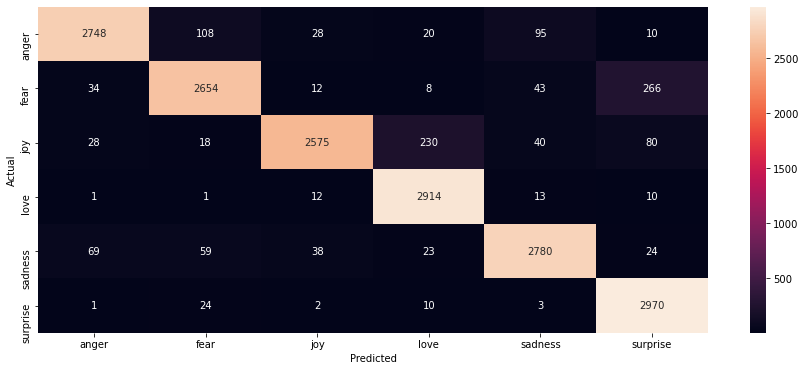

In [52]:
cm = show_confusion_matrix(y_test, preds, classes)

## 2- Over Sampling

there will be an overfitting data leakage because the model will train on samples that will see again on the test set

In [53]:
max_class_count = max(data['emotions'].value_counts())

grouped = data.groupby('emotions')['text'].apply(lambda x: x.sample(max_class_count, replace=True))
data_over = grouped.reset_index()
data_over.drop(['level_1'], axis=1, inplace=True)
data_over = data_over.sample(frac=1)
data_over.reset_index(inplace=True, drop=True)
data_over.emotions.value_counts()

love        140779
fear        140779
surprise    140779
anger       140779
joy         140779
sadness     140779
Name: emotions, dtype: int64

In [54]:
text = data_over['text'].values
y = data_over['emotions'].values

y_sparse = to_indices(y)
# y_hot = to_categorical(y_sparse)

X_train, X_test, y_train, y_test = train_test_split(text, y_sparse, test_size=0.2)

Preprocessing Text

In [55]:
tokenizer, X_train_processed  = preprocess(X_train)
X_test_processed = preprocess(X_test, tokenizer)

Resetting The Model

In [56]:
model.load_weights(initial_weights);

Training Phase

In [57]:
%%time
epochs = 2
# checkpoint = ModelCheckpoint('sparse_model_dl_W_1.h5', save_weights_only=True)

history = model.fit(X_train_processed, y_train, validation_split=0.2, epochs=epochs, batch_size=32)

Train on 540591 samples, validate on 135148 samples
Epoch 1/2
540591/540591 [==============================] - 219s 406us/sample - loss: 0.3449 - accuracy: 0.8635 - val_loss: 0.1200 - val_accuracy: 0.9494
Epoch 2/2
540591/540591 [==============================] - 218s 403us/sample - loss: 0.1103 - accuracy: 0.9536 - val_loss: 0.1053 - val_accuracy: 0.9543
Wall time: 7min 17s


Model Progress

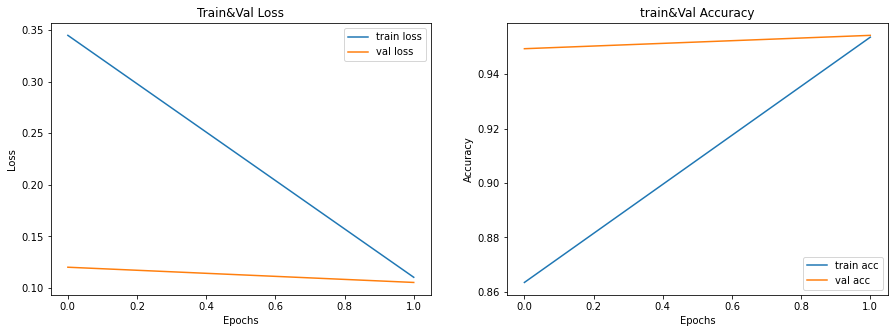

In [58]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plot_progress(train_loss, val_loss, train_acc, val_acc, epochs)

### Evaluating Phase

In [59]:
%%time
model.evaluate(X_test_processed, y_test, verbose=0)

Wall time: 25.1 s


[0.1086559659483963, 0.9535206]

In [60]:
preds = model.predict_classes(X_test_processed)

print(classification_report(y_test, preds, target_names=classes))

              precision    recall  f1-score   support

       anger       0.96      0.96      0.96     28089
        fear       0.95      0.90      0.92     28178
         joy       0.99      0.91      0.95     28197
        love       0.93      1.00      0.96     28320
     sadness       0.99      0.95      0.97     28003
    surprise       0.91      1.00      0.95     28148

    accuracy                           0.95    168935
   macro avg       0.96      0.95      0.95    168935
weighted avg       0.96      0.95      0.95    168935



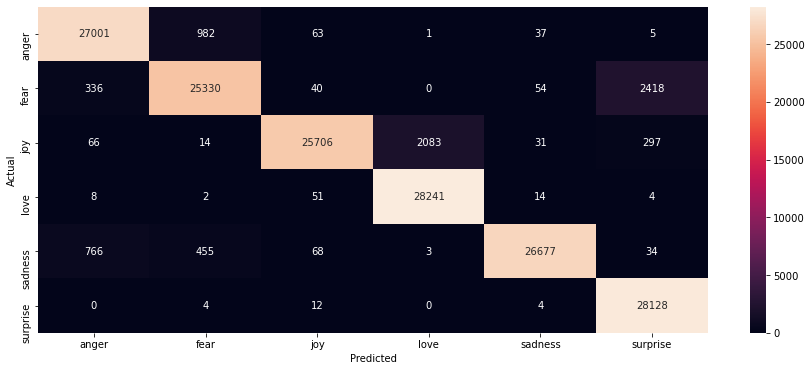

In [61]:
cm = show_confusion_matrix(y_test, preds, classes)

## 3- Class Weights

In [62]:
weight_for_anger = (1 / v['anger'])*(v.sum())/n_classes
weight_for_fear = (1 / v['fear'])*(v.sum())/n_classes
weight_for_joy = (1 / v['joy'])*(v.sum())/n_classes
weight_for_love = (1 / v['love'])*(v.sum())/n_classes
weight_for_sadness = (1 / v['sadness'])*(v.sum())/n_classes
weight_for_surprise = (1 / v['surprise'])*(v.sum())/n_classes

class_weight = {np.where(classes == 'anger')[0][0]:weight_for_anger,
                np.where(classes == 'fear')[0][0]:weight_for_fear,
                np.where(classes == 'joy')[0][0]:weight_for_joy,
                np.where(classes == 'love')[0][0]:weight_for_love,
                np.where(classes == 'sadness')[0][0]:weight_for_sadness,
                np.where(classes == 'surprise')[0][0]:weight_for_surprise}
class_weight

{0: 1.2117381555574969,
 1: 1.4550569262616089,
 2: 0.4926433156460362,
 3: 2.0104308587220143,
 4: 0.5732242876074133,
 5: 4.636261336542104}

In [63]:
text = data['text'].values
y = data['emotions'].values

y_sparse = to_indices(y)
# y_hot = to_categorical(y_sparse)

X_train, X_test, y_train, y_test = train_test_split(text, y_sparse, test_size=0.2)

In [64]:
tokenizer, X_train_processed  = preprocess(X_train)
X_test_processed = preprocess(X_test, tokenizer)

Resetting The Model

In [65]:
model.load_weights(initial_weights);

Training Phase

In [66]:
%%time
epochs = 2
# checkpoint = ModelCheckpoint('sparse_model_dl_W_1.h5', save_weights_only=True)

history = model.fit(X_train_processed, y_train, validation_split=0.2, epochs=epochs, batch_size=32,
                    class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 266318 samples, validate on 66580 samples
Epoch 1/2
266318/266318 [==============================] - 113s 423us/sample - loss: 0.3298 - accuracy: 0.8535 - val_loss: 0.1393 - val_accuracy: 0.9310
Epoch 2/2
266318/266318 [==============================] - 111s 417us/sample - loss: 0.1204 - accuracy: 0.9364 - val_loss: 0.1144 - val_accuracy: 0.9379
Wall time: 3min 43s


Model Progress

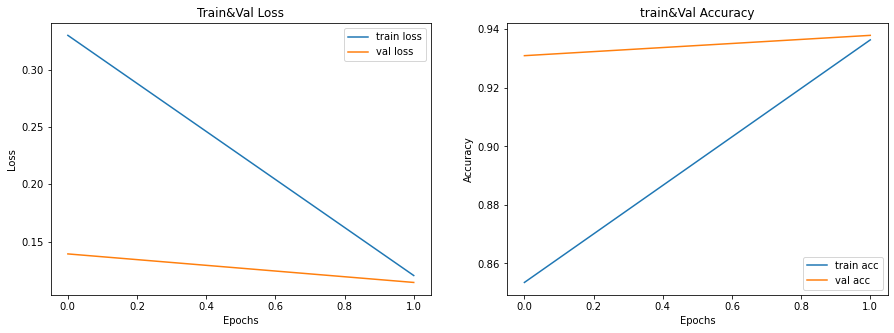

In [67]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plot_progress(train_loss, val_loss, train_acc, val_acc, epochs)

### Evaluating Phase

In [68]:
%%time
model.evaluate(X_test_processed, y_test, verbose=0)

Wall time: 12.8 s


[0.11731937366033342, 0.93948936]

In [69]:
preds = model.predict_classes(X_test_processed)

print(classification_report(y_test, preds, target_names=classes))

              precision    recall  f1-score   support

       anger       0.93      0.95      0.94     11460
        fear       0.90      0.90      0.90      9603
         joy       1.00      0.91      0.95     28039
        love       0.77      1.00      0.87      6887
     sadness       1.00      0.95      0.98     24172
    surprise       0.73      1.00      0.84      3064

    accuracy                           0.94     83225
   macro avg       0.89      0.95      0.91     83225
weighted avg       0.95      0.94      0.94     83225



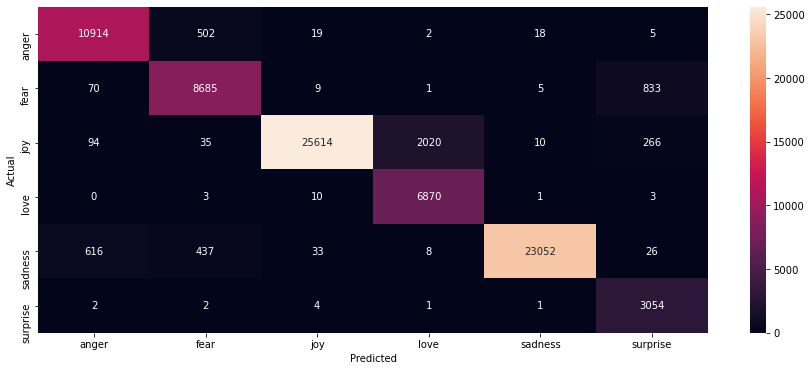

In [70]:
cm = show_confusion_matrix(y_test, preds, classes)